# Batch run phenology analysis

Qsub each tile

In [1]:
%matplotlib inline

import os
import sys
import warnings
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs

## Open data

In [2]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/NDVI/NDVI_smooth_AusENDVI-clim_MCD43A4.nc')['NDVI']
covariables =  xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/covars.nc')
covariables = covariables.drop_vars('wcf')

#testing slices
# ds = ds.isel(latitude=slice(200,352), longitude=slice(50,302)) 
# covariables = covariables.isel(latitude=slice(200,352), longitude=slice(50,302))

# ds = ds.isel(latitude=slice(200,252), longitude=slice(50,202)) 
# covariables = covariables.isel(latitude=slice(200,252), longitude=slice(50,202))

## Split data into tiles

Running all of Aus just takes too long, >500,000 pixels * > 14,000 time steps - dask graph is huge!

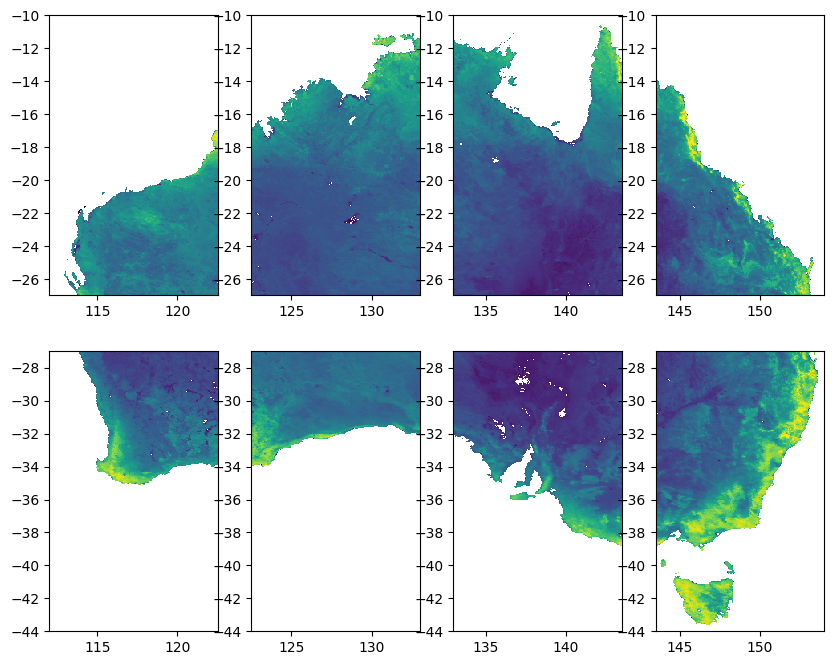

In [3]:
# Function to split into spatial tiles
def split_spatial_tiles(data_array, lat_dim='latitude', lon_dim='longitude', n_lat=2, n_lon=4):
    lat_size = data_array.sizes[lat_dim] // n_lat
    lon_size = data_array.sizes[lon_dim] // n_lon
    
    tiles = []
    for i in range(n_lat):
        for j in range(n_lon):
            tile = data_array.isel({
                lat_dim: slice(i * lat_size, (i + 1) * lat_size),
                lon_dim: slice(j * lon_size, (j + 1) * lon_size)
            })
            tiles.append(tile)
    
    return tiles

# Split data into spatial tiles (2 latitude x 4 longitude)
tiles = split_spatial_tiles(ds, n_lat=2, n_lon=4)
covars_tiles = split_spatial_tiles(covariables, n_lat=2, n_lon=4)

#verify no overlaps or missing pixels.
assert np.sum(xr.combine_by_coords(tiles).longitude == ds.longitude) == len(ds.longitude)
assert np.sum(xr.combine_by_coords(tiles).latitude == ds.latitude) == len(ds.latitude)

# create named dictonary
tile_names=['NW', 'NNW', 'NNE', 'NE',
            'SW', 'SSW', 'SSE', 'SE']
tiles_dict = dict(zip(tile_names, tiles))
covars_tiles_dict = dict(zip(tile_names, covars_tiles))

#create a plot to visualise tiles
fig,axes = plt.subplots(2, 4, figsize=(10,8))
for t,ax in zip(tiles, axes.ravel()):
    t.isel(time=range(0,20)).mean('time').plot(ax=ax, add_colorbar=False, add_labels=False)
    ax.set_title(None);

## Export

In [4]:
for k,v in tiles_dict.items():
    print(k)
    v.to_netcdf(f'/g/data/os22/chad_tmp/Aus_phenology/data/tiled_data/NDVI_{k}.nc')

NW


/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


NNW
NNE
NE
SW
SSW
SSE
SE


In [5]:
for k,v in covars_tiles_dict.items():
    print(k)
    v.to_netcdf(f'/g/data/os22/chad_tmp/Aus_phenology/data/tiled_data/COVARS_{k}.nc')

NW
NNW
NNE
NE
SW
SSW
SSE
SE


## Submit tiles to PBS job queue

In [6]:
import os

In [10]:
tiles = ["'NW'", "'NNW'", "'NNE'", "'NE'", "'SW'", "'SSW'", "'SSE'", "'SE'"] #,"'NW'", 
os.chdir('/g/data/os22/chad_tmp/Aus_phenology/')
for t in tiles:
    print(t)
    os.system("qsub -v TILENAME="+t+" src/run_single_tile.sh")

'NW'
128224582.gadi-pbs
'NNW'
128224583.gadi-pbs
'NNE'
128224584.gadi-pbs
'NE'
128224585.gadi-pbs
'SW'
128224586.gadi-pbs
'SSW'
128224587.gadi-pbs
'SSE'
128224588.gadi-pbs
'SE'
128224589.gadi-pbs


In [15]:
!qstat
# !qstat -xf 127454605.gadi-pbs

Job id                 Name             User              Time Use S Queue
---------------------  ---------------- ----------------  -------- - -----
128223074.gadi-pbs     sys-dashboard-s* cb3058            02:12:41 R normalsr-exec   
128224582.gadi-pbs     run_single_tile* cb3058            06:15:25 R normalsr-exec   
128224583.gadi-pbs     run_single_tile* cb3058            07:41:24 R normalsr-exec   
128224584.gadi-pbs     run_single_tile* cb3058            06:47:33 R normalsr-exec   
128224585.gadi-pbs     run_single_tile* cb3058            08:17:21 R normalsr-exec   
128224586.gadi-pbs     run_single_tile* cb3058            03:19:08 R normalsr-exec   
128224587.gadi-pbs     run_single_tile* cb3058            02:47:06 R normalsr-exec   
128224588.gadi-pbs     run_single_tile* cb3058            04:35:41 R normalsr-exec   
128224589.gadi-pbs     run_single_tile* cb3058            04:15:08 R normalsr-exec   


## Run interactively instead

Good for testing etc.

In [ ]:
import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import start_local_dask

sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from batch_run_phenology_analysis import phenometrics_etal

In [ ]:
## varibles for script
n_workers=13
memory_limit='60GiB'
integral_var = 'IOS'
regress_var = 'vPOS'
modelling_vars=['co2', 'srad', 'rain', 'tavg', 'vpd']
results_path = '/g/data/os22/chad_tmp/Aus_phenology/results/combined_tiles/'
template_path='/g/data/os22/chad_tmp/Aus_phenology/data/templates/'

In [ ]:
start_local_dask(
        n_workers=n_workers,
        threads_per_worker=1,
        memory_limit=memory_limit
                    )

In [ ]:
tiles = ['NW','NNW', 'NNE', 'NE', 'SW', 'SSW', 'SSE', 'SE']

for t in tiles:
    print(t)
    phenometrics_etal(
        n=t,
        results_path=results_path,
        template_path=template_path,
        integral_var=integral_var,
        regress_var=regress_var,
        modelling_vars=modelling_vars,
    )
    break

In [ ]:
import xarray as xr

In [ ]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/combined_tiles/trends_phenology_perpixel_NW.nc')
ds

In [ ]:
(ds['LOS_slope']).plot(robust=True)

In [ ]:
(ds['IOC_slope']).plot(robust=True)

In [ ]:
# (ds['vTOS']).plot(vmin=0.1, vmax=0.9)

In [ ]:
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs

In [ ]:
ss_path = f'/g/data/xc0/project/AusEFlux/data/ndvi_of_baresoil_5km.nc'
ss = assign_crs(xr.open_dataarray(ss_path), crs='epsg:4326')
ss

In [ ]:
np.isnan(ss).plot()

In [ ]:
soil_signal = 0.14

In [ ]:
if isinstance(soil_signal, float):
    pass

if isinstance(soil_signal, xr.DataArray):
   print('xarray')

In [ ]:
import xarray as xr

In [ ]:
# (ds['IOC'] - ds['IOS']).plot(size=6, robust=True)

In [ ]:
# ds['IOC'].plot(size=6, robust=True)

In [ ]:
import pickle
product='AusENDVI-clim_MCD43A4'
base = '/g/data/os22/chad_tmp/Aus_phenology/'
phenometrics_file = f'{base}data/pickle/IBRA_subregions_{product}_phenometrics.pkl'

In [ ]:
with open(phenometrics_file, 'rb') as f:
    phenometrics = pickle.load(f)

In [ ]:
r = 'Warre'
ds = phenometrics[r].to_xarray()
ds = ds.rename({'IOS':'IOC'})

In [ ]:
from phenology_pixel import IOS_analysis

In [ ]:
ds['LOS*vPOS'] = ds['IOC']

In [ ]:
template_path='/g/data/os22/chad_tmp/Aus_phenology/data/templates/'
template = xr.open_dataset(f'{template_path}template_IOC_parcorr.nc')

IOS_analysis(ds.expand_dims(latitude=[-33.0],longitude=[135.0]),
             template=template).compute()

In [ ]:
ds['POS_year'].values[0]

In [ ]:
range(     ds['POS_year'].values[-1]

In [ ]:
[i for i in range(int(b),int(a)+1)]

In [ ]:
n_seasons = len(ds.index) 
print(n_seasons)
a = ds['POS_year'].values[0]
b = ds['POS_year'].values[-1]

n_years = len([i for i in range(int(a),int(b)+1)])
print(n_years)
print('season/yr', n_seasons / n_years) 

In [ ]:
phenometrics['Alice Tableland']['POS_year'][-1:].item()

In [ ]:
import xarray as xr
dss = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/templates/template_IOS.nc')
ds = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/templates/template_parcorr.nc')

dss['latitude'] = ds.latitude
dss['longitude'] = ds.longitude

ds['slope_IOC_vs_LOS*vPOS'] = dss['slope_IOS_vs_LOS*vPOS']
ds['pearson_r_IOC_vs_LOS*vPOS'] = dss['pearson_r_IOS_vs_LOS*vPOS']
print(ds)
ds.to_netcdf('/g/data/os22/chad_tmp/Aus_phenology/data/templates/template_IOC_parcorr.nc')

In [ ]:
import xarray as xr

In [ ]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/templates/template.nc')

In [ ]:
ds = ds.rename({'IOC:(LOS*vPOS)':'IOS:(LOS*vPOS)'})

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/Aus_phenology/data/templates/template_.nc')

In [ ]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/templates/template_IOC_parcorr.nc')
ds = ds.drop_vars(['slope_IOC_vs_LOS*vPOS', 'pearson_r_IOC_vs_LOS*vPOS', 'vTOS'])
ds

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/Aus_phenology/data/templates/template_integral_parcorr.nc')